In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.spatial import cKDTree
from bb_opt.src.knn_mi import estimate_mi
from gpu_utils.utils import gpu_init

gpu_id = gpu_init()
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

Running on GPU 1


# MINE

In [2]:
sigma_x = .7
sigma_y = .5
sigma_xy = .3
cov = np.array([[sigma_x, sigma_xy], [sigma_xy, sigma_y]]) ** 2
mu = [0, 0]

def sample_xy():
    x, y = np.random.multivariate_normal(mu, cov, n_samples).T
    x = x[:, None]
    y = y[:, None]
    return x, y

In [3]:
mi = - 1 / 2 * np.log(1 - (sigma_xy / (sigma_x * sigma_y)) ** 2)
mi

0.6634354703245452

In [4]:
# data
var = 0.2
def func(x):
    return x
#     return np.sin(x)

def sample_xy():
#     x = np.random.normal(0, 1, [data_size, 1])
    x = np.sign(np.random.normal(0., 1., [n_samples, 1]))
    y = func(x) + np.random.normal(0, np.sqrt(var), [n_samples, 1])
    return x, y

n_samples = 1000000
x, y = sample_xy()
p_y_x = np.exp(-(y - x) ** 2 / (2 * var))
p_y_x_minus = np.exp(-(y + 1) ** 2 / (2 * var))
p_y_x_plus = np.exp(-(y - 1) ** 2 / (2 * var))
mi = np.average(np.log(p_y_x / (0.5 * p_y_x_minus + 0.5 * p_y_x_plus)))
mi

0.6588447277483649

In [5]:
H = 10
n_epoch = 500
n_samples = 20000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = torch.relu(self.fc1(x) + self.fc2(y))
        h2 = self.fc3(h1)
        return h2

model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

plot_loss = []
for epoch in range(n_epoch):
    x_sample, y_sample = sample_xy()
    y_shuffle = np.random.permutation(y_sample)
    
    x_sample = torch.tensor(x_sample, dtype=torch.float32, device=device, requires_grad=True)
    y_sample = torch.tensor(y_sample, dtype=torch.float32, device=device, requires_grad=True)
    y_shuffle = torch.tensor(y_shuffle, dtype=torch.float32, device=device, requires_grad=True)    
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = - ret  # maximize
    plot_loss.append(loss.item())
    
    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(epoch, end=" ")

0 50 100 150 200 250 300 350 400 450 

In [6]:
n_samples = 10_000

xy = sample_xy()
xy = np.stack(xy).squeeze()
mi_ksg = estimate_mi(xy, method="KSG")
mi_lnc = estimate_mi(xy)

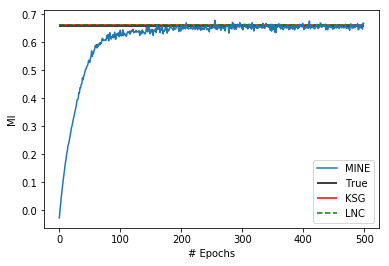

In [10]:
plot_x = np.arange(len(plot_loss))
plot_y = np.array(plot_loss).reshape(-1,)

plt.plot(plot_x, -plot_y, label="MINE")
plt.hlines(mi, plot_x.min(), plot_x.max(), label="True")
plt.hlines(mi_ksg, plot_x.min(), plot_x.max(), label="KSG", colors="r")
plt.hlines(mi_lnc, plot_x.min(), plot_x.max(), label="LNC", colors="g", linestyles="dashed")

plt.ylabel("MI")
plt.xlabel("# Epochs")
plt.legend()

# kNN-MI and LNC

In [11]:
n_samples = 10_000

xy = sample_xy()
xy = np.stack(xy).squeeze()

In [12]:
%%timeit
estimate_mi(xy)

440 ms ± 7.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
estimate_mi(xy, method="KSG")

399 ms ± 5.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
estimate_mi(xy), estimate_mi(xy, method="KSG")

(0.6564674510328236, 0.6542902021813628)

In [15]:
from sklearn import neighbors

In [ ]:
neighbors.LSHForest()

In [15]:
X = np.random.random((10_000, 3))
tree = neighbors.KDTree(X, p=float("inf"))

In [21]:
X = np.random.random((10, 3))
tree = neighbors.BallTree(X, p=float("inf"))

In [27]:
tree.query_radius(X, [.3] * len(X))

array([array([0, 2, 9]), array([1]), array([0, 2, 8, 9]), array([3]),
       array([4, 7]), array([5]), array([6]), array([4, 7]),
       array([2, 8, 9]), array([0, 2, 8, 9])], dtype=object)

In [18]:
q = torch.tensor(xy, device=device)
q

tensor([[-1.0000,  1.0000, -1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [-1.2767,  1.2997, -0.2671,  ...,  1.5881,  0.9844,  0.3332]],
       device='cuda:0', dtype=torch.float64)

In [20]:
%%timeit
estimate_mi(q.cpu().numpy())

426 ms ± 7.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
